In [1]:
from helper_functions import make_counts_df

In [21]:
import os
import numpy as np
import pandas as pd
import plotly_factory as plf
from plotly_factory import *
import plotly.graph_objs as go

import plotly as pl
import numpy as np
import pandas as pd
import plotly.graph_objs as go
from collections import OrderedDict, defaultdict
from datetime import datetime
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy import stats

import os
import numpy as np
import pandas as pd
import plotly.graph_objs as go
from collections import OrderedDict
from plotly.io import write_html

df_serbia = pd.read_csv("data\df_serbia_englang.csv")
df_germany = pd.read_csv("data\df_germany_englang.csv").sample(n=len(df_serbia))
df = pd.concat([df_serbia, df_germany], sort=False)


In [ ]:
manufacturers_germany = plf.plot_horizontal_count_bars(
    df_germany, "manufacturer",
    first_n=12, show_percentage=False, text_position="auto",
    colorscale="mint",
)
manufacturers_germany.update_layout(
    title=plf.title_layout(
        "<b>German</b> market", title_size=20, color="#52527a"),
    yaxis=plf.axis_layout(
        "Car brand", showticklabels=False),
    xaxis=plf.axis_layout(
        "Number of Cars", tick_size=16, dtick=2000, range_=[0, 12000], show_exponent="last", show_grid=True),
)
manufacturers_germany.show(renderer="svg", width = 800, height=550)

In [5]:
models_per_manuf_serbia = make_counts_df(
    df_serbia, "manufacturer", "model", 6, 5, add_percentage=True, bold=True)
models_per_manuf_germany = make_counts_df(
    df_germany, "manufacturer", "model", 6, 5, add_percentage=True)

In [6]:
mod_per_manuf_serbia = plf.plot_table(
    models_per_manuf_serbia,
    cell_align="left", 
    header_align="center", 
    cell_height=48,
    transparent=True
)

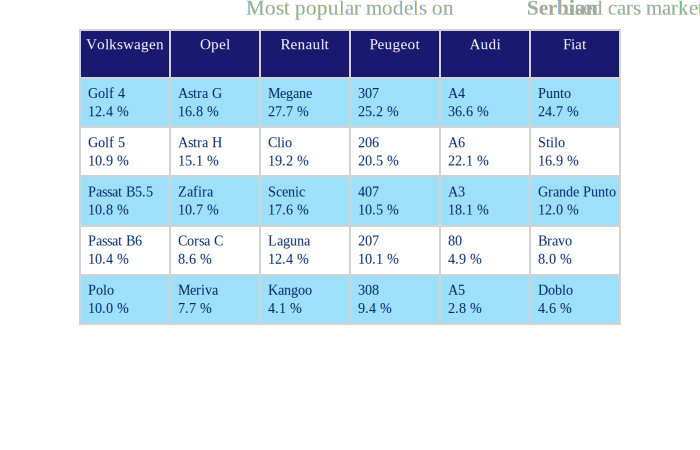

In [8]:
mod_per_manuf_serbia.layout.update(
    title=plf.title_layout(
        "Most popular models on <b>Serbian</b> used cars market", 
        y_position=1
        ),
    margin={"t":30, "b":0},
)
mod_per_manuf_serbia.show(renderer="svg")


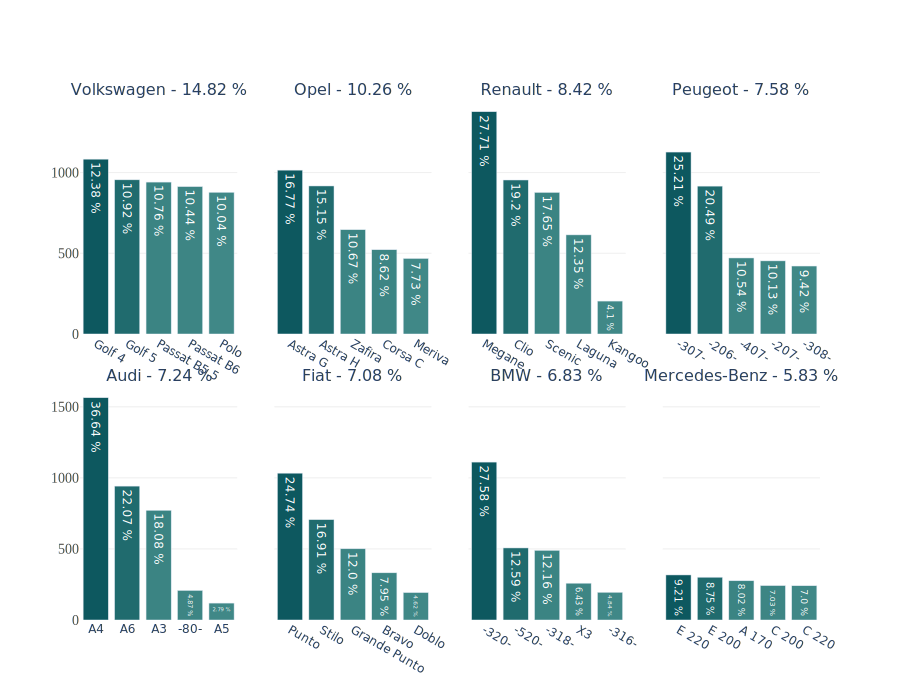

In [9]:
subplots = plf.plot_count_subplots(df_serbia, "manufacturer", "model", 2, 4, 5, show_main_percentages=True,  transparent=True, share_x=False)
subplots.show(renderer="svg", height = 700, width=900)

In [198]:
def plot_heatmap(df_corr, colorscale="brwnyl", cut_in_half = False, showscale=True, textfont="default", xgap=1, ygap=1, transparent=True):
    
    if textfont=="default":
        textfont = {
                "color": "#000000",
                "size": 14,
                "family": "Times New Roman"
        }
    
    trace=go.Heatmap(
        colorscale=colorscale,
        hoverinfo="text",
        xgap=xgap,
        ygap=ygap,
        showscale=showscale
    )
    
    if cut_in_half:
        corr_triangle = np.array([[None for k in range(df_corr.shape[1]-1)] for j in range(df_corr.shape[0]-1)])
        for k, vals in enumerate(df_corr[1:].values):
            corr_triangle[k][:k+1] = np.round(vals[:k+1], 2)

        trace.update(z = corr_triangle[::-1], x = df_corr.index[:-1], 
                     y = df_corr.index[1:][::-1], text = corr_triangle[::-1])
        fig = go.Figure(data=[trace])
        
        annotations = []
        for k, y in enumerate(df_corr.index):
            for x in df_corr.index[:k]:
                anot = go.layout.Annotation(
                    x=x,
                    y=y,
                    xref="x",
                    yref="y",
                    text = f"<b>{df_corr[x][y]: .2f}</b>",
                    showarrow=False,
                    font = textfont
                )
                annotations.append(anot)

    else:
        trace.update(z = df_corr.values[::-1], x = df_corr.index, 
                     y = df_corr.index[::-1], text= np.round(df_corr.values[::-1], 2))
        fig = go.Figure(data=[trace])
        annotations = []
        for k, y in enumerate(df_corr.index):
            for x in df_corr.index:
                anot = go.layout.Annotation(
                    x=x,
                    y=y,
                    xref="x",
                    yref="y",
                    text = f"<b>{df_corr[x][y]: .2f}</b>",
                    showarrow=False,
                    font = textfont
                )
                annotations.append(anot)
    
    fig.update_layout(
        showlegend=False,
        annotations=annotations
    )
    
    if transparent:
        fig.update_layout(
            plot_bgcolor="rgba(0,0,0,0)",
            paper_bgcolor="rgba(0,0,0,0)"
            )
    return fig

In [199]:
corr_germany_dizel = df_germany[["year", "price", "mileage"]].loc[df_germany.fuel_type=="Diesel"].corr("spearman")
corr_serbia_dizel = df_serbia[["year", "price", "mileage"]].loc[df_serbia.fuel_type=="Diesel"].corr("spearman")

corr_germany_benzin = df_germany[["year", "price", "mileage"]].loc[df_germany.fuel_type=="Gasoline"].corr("spearman")
corr_serbia_benzin = df_serbia[["year", "price", "mileage"]].loc[df_serbia.fuel_type=="Gasoline"].corr("spearman")

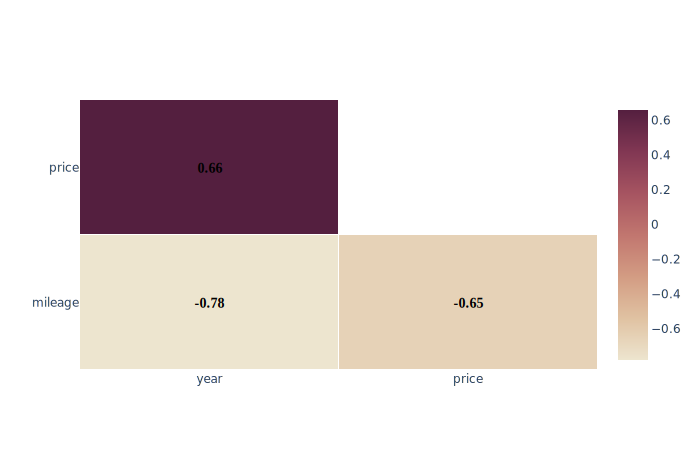

In [200]:
plot_heatmap(corr_germany_dizel, cut_in_half=True, showscale=True).show(renderer="svg")